# Parking Lot Diagram
In this notebook, we'll using the OpenCV (`cv2`) Python library to capture the lines of the parking lot as well as representing the empty spaces as rectangles.

## Notebook Setup

In [1]:
# Importing the necessary Python libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading in the raw parking lot image
raw_img = cv2.imread('../data/raw/empty_parking_lot.jpeg')

# Color correcting the image from BGR to RGB
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# Converting the image to grayscale
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

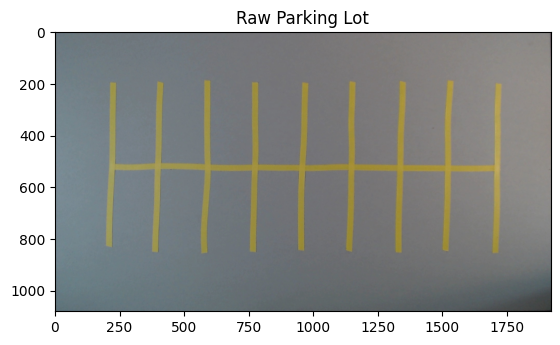

In [3]:
# Viewing the raw parking lot
plt.title('Raw Parking Lot')
plt.imshow(raw_img);

## Masking on the Yellow Color

Because we know our parking lot has distinct yellow lines, we can create a **mask** that looks specifically just for that yellow-like color. In order to do this, we'll need to use an HSV version of the image, which you might recall we had to use in our image processing notebook for color equalization. Since we have to do this anyway, I'm going to go ahead and apply a color equalization to make that color really pop.

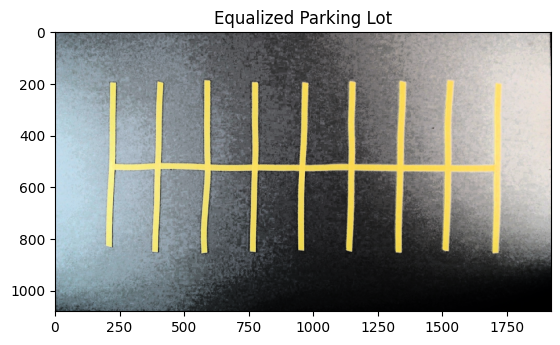

In [4]:
# Converting our raw parking lot image from its current RGB to HSV
hsv_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HSV)

# Applying the color equalization to the HSV image
hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2])

# Converting the image from HSV to RGB for display purposes
equalized_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

# Displaying the equalized parking lot
plt.title('Equalized Parking Lot')
plt.imshow(equalized_img);

Now, we have this image that is really distinct in terms of that yellow color compared to the rest of the image. What we're going to do now is create lower and upper bounds that generally represent the yellow color, and then we're going to create this mask from the HSV image that will only grab that yellow color

In [5]:
# Defining the lower and upper bounds for the yellow mask
lower_yellow = np.array([22, 93, 0], dtype = 'uint8')
upper_yellow = np.array([45, 255, 255], dtype = 'uint8')

In [6]:
# Extracting the parking lot lines our yellow mask boundaries and HSV image
parking_lines = cv2.inRange(hsv_img, 
                            lowerb = lower_yellow,
                            upperb = upper_yellow)

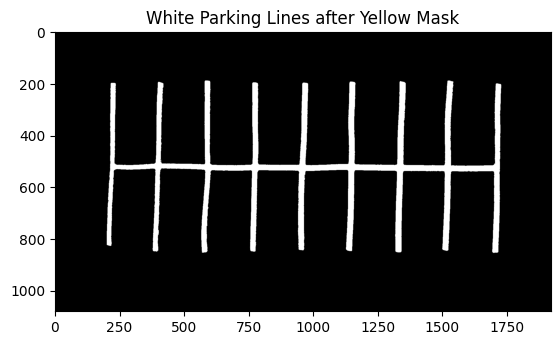

In [7]:
# Displaying the parking lines after applying the yellow mask
plt.title('White Parking Lines after Yellow Mask')
plt.imshow(parking_lines, cmap = 'gray');

## Colorizing the Parking Lot Diagram
Great! Now that we've successfully extracted the parking lines from the original image as a binary black and white image, let's go ahead and re-colorize the image to be more appropriate to look like a parking lot. I am going to grab the RGB color for the yellow parking lot lines [from this website](https://colorcodes.io/yellow/road-sign-yellow-color-codes/), and I'm going to grab the gray background for the parking lot [from this website](https://colorcodes.io/gray/asphalt-gray-color-codes/). Here are what those respective colors are in RGB format:

- **Road sign yellow**: (253, 218, 22)
- **Asphalt gray**: (128, 126, 120)

In [8]:
# Converting grayscale parking lines to RGB
colorized_parking_lines = cv2.cvtColor(parking_lines, cv2.COLOR_GRAY2RGB)

In [9]:
# Setting the currently white parking lines to our new yellow color
colorized_parking_lines[np.where((colorized_parking_lines == [255, 255, 255]).all(axis = 2))] = [253, 218, 22]

# Setting the currently black background to our new gray color
colorized_parking_lines[np.where((colorized_parking_lines == [0, 0, 0]).all(axis = 2))] = [128, 126, 120]

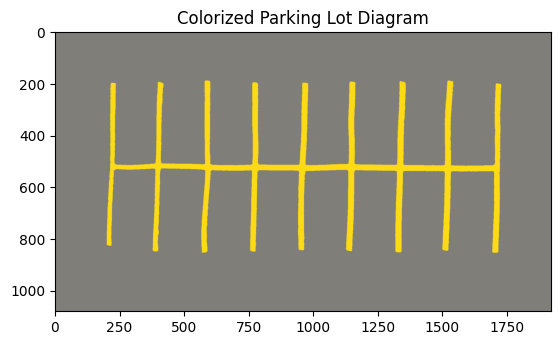

In [10]:
# Viewing our newly colorized parking lot
plt.title('Colorized Parking Lot Diagram')
plt.imshow(colorized_parking_lines);

## Detecting the Empty Parking Spaces
Now that we have created our general parking lot diagram, we're going to need to programatically figure out how to detect the empty spaces. This can be a tricky problem to solve, and we're going to go about it in a bit of a creative way. Transparently, this way isn't going to work on every single parking lot, but for our purposes with our simple parking lot here, this process will work just fine!

### Enclosing the Spaces
Without jumping ahead too much, the easiest way to detect a parking space is by essentially making it its own rectangle. If you look at each space on it's own right now, it's basically a 3-sided rectangle, so we have to figure out a way to enclose that last side.

Fortunately, since our parking lot is simple and uniform, we can enclose the entire thing with a single rectangle. We're going to use a special functionality of `cv2` called `cv2.boundingRect()`. Since we still currently have a variable with our grayscale parking lines, we can use this function to detect the four corners of our existing parking lines. As a reminder, here's the grayscale image of the parking lines we'll be working with from here. (This is the same as a few cells above.)

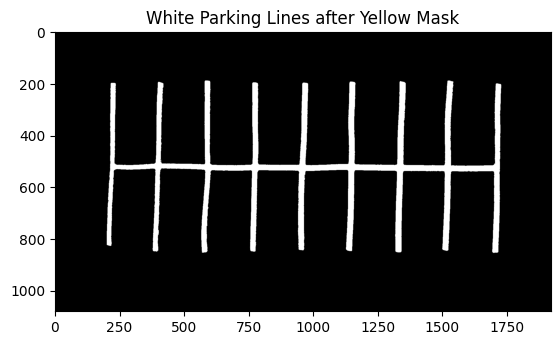

In [11]:
# Displaying the parking lines after applying the yellow mask
plt.title('White Parking Lines after Yellow Mask')
plt.imshow(parking_lines, cmap = 'gray');

Now, let's use the `cv2.boundingRect()` function to grab 4 pieces of information:

- `x`: This is the x-coordinate of the top left corner of the parking lines.
- `y`: This is the y-coordinate of teh top left corner of the parking lines.
- `w`: This is the width of the rectangle starting from the provided x-coordinate (`x`).
- `h`: This is the height of the rectangle starting from the provided y-coordinate (`y`).

In [12]:
# Getting top left x and y coordinates, width, and height of the parking lines
x, y, w, h = cv2.boundingRect(parking_lines)

With this information from `cv2.boundingRect()`, we can now enclose the parking spaces with a single rectangle in the next cell!

In [13]:
# Drawing a rectangle to enclose the parking spaces.
cv2.rectangle(parking_lines, pt1 = (x, y),
              pt2 = (x + w, y + h), color = (255, 255, 255),
              thickness = 50)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

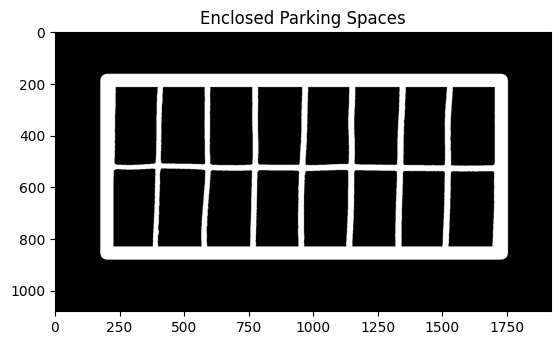

In [14]:
# Viewing the enclosed parking spaces
plt.title('Enclosed Parking Spaces')
plt.imshow(parking_lines, cmap = 'gray');

### Extracting Just the Parking Spaces
Given that the only thing we're really concerned about are the empty parking spaces, we need to have the parking spaces be just one color and make everything else a singular color. In order to do this, we're going to make an inverted copy of the parking spaces and then copy the inverted parking spaces onto a pure black canvas. In order to perform a simple inversion (since we have binary colors), we can use the `cv2.bitwise_not()` function.

In [15]:
# Inverting the colors of the parking lines
inv_parking_lines = cv2.bitwise_not(parking_lines)

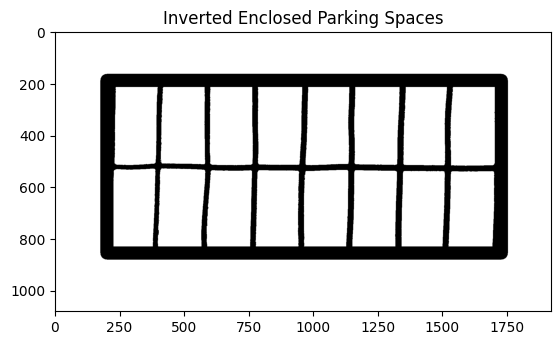

In [16]:
# Displaying the inverted parking lines
plt.title('Inverted Enclosed Parking Spaces')
plt.imshow(inv_parking_lines, cmap = 'gray');

When we copy one portion of an image onto another, we call that desired portion of the image the **region of interest (ROI)**. Let's grab the ROI from the original parking lot using the same information we got from `cv2.boundingRect()`.

In [17]:
# Getting the region of interest from parking_lines
roi = inv_parking_lines[y:y + h, x: x + w]

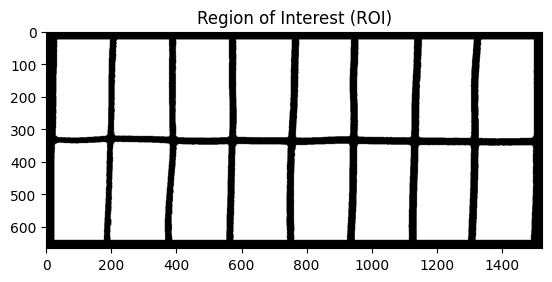

In [18]:
# Displaying the region of interest
plt.title('Region of Interest (ROI)')
plt.imshow(roi, cmap = 'gray');

Now that we've established our region of interest (ROI), let's create a new blank, black canvas. We can do this using the `np.zeros()` function. What this Numpy function does is create an array of nothing but 0s per the shape that we pass into it. Given that we want this canvas to be the same size as our original `parking_lines` variable, we're going to set the shape to be that.

In [19]:
# Instantiating a new black canvas
parking_spaces = np.zeros(parking_lines.shape, dtype = np.uint8)

Because these images are simply arrays of Numpy values, we can do some simple indexing against this new background to set where we want to place our region of interest (ROI)

In [20]:
# Applying the region of interest on our black backround
parking_spaces[y: y + h, x: x + w] = roi

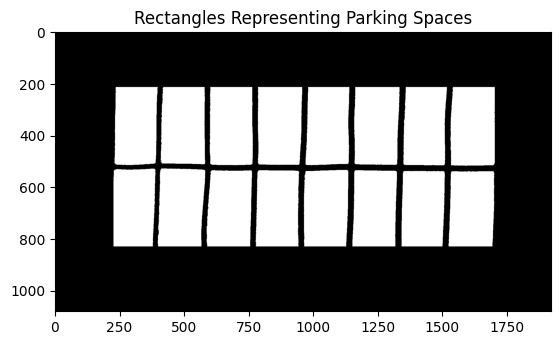

In [21]:
# Viewing the rectangles representing our parking spaces
plt.title('Rectangles Representing Parking Spaces')
plt.imshow(parking_spaces, cmap = 'gray');

### Eroding the Boundaries of the Parking Spaces
To give you a sneak peek at what we're going to do next, we are going to be using a special function called `cv2.findContours()` that is essentially going to look for the rectangles representing the empty parking spaces as individual objects. In order for this function to work the most properly, it will be ideal to widen the black borders between each of the white rectangles. To do this, we're going to **erode** the rectangles using OpenCV's `cv2.erode()` function. Let's see how this works in action!

In [22]:
# Creating a custom kernel using Numpy's "ones" function to utilize for the erosion
kernel = np.ones((7, 7), dtype = np.uint8)

In [31]:
# Eroding the rectangles representing the parking spaces
eroded_spaces = cv2.erode(parking_spaces,
                          kernel = kernel,
                          iterations = 2)

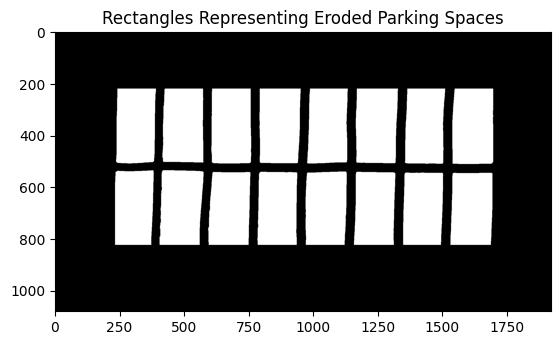

In [32]:
# Displaying the eroded spaces
plt.title('Rectangles Representing Eroded Parking Spaces')
plt.imshow(eroded_spaces, cmap = 'gray');

## Detecting the "Contours" Representing the Empty Spaces
Okay, now that we have eroded the rectangles, we have increased our changes that OpenCV will be able to detect the empty spaces represented by the white rectangles. We call this sort of detection **contour detection**, and as we mentioned above, the OpenCV function to enable this is `cv2.findContours()`. After detecting the contours, we'll go ahead and draw these contours back onto our same eroded spaces diagram with a green border.

In [33]:
# Detecting the contours representing the empty spaces
empty_spaces, hierarchy = cv2.findContours(eroded_spaces,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

In [34]:
# Turning eroded_spaces from grayscale to RGB
eroded_spaces = cv2.cvtColor(eroded_spaces, cv2.COLOR_GRAY2RGB)

# Drawing the contours back onto the eroded spaces diagram
for space in empty_spaces:
    
    cv2.drawContours(eroded_spaces, contours = [space],
                     contourIdx = -1, color = (0, 255, 0), thickness = 10)

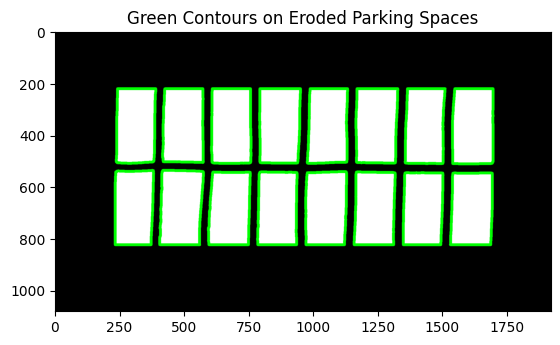

In [35]:
# Displaying the green contours on the eroded spaces
plt.title('Green Contours on Eroded Parking Spaces')
plt.imshow(eroded_spaces);

## Combining the Parking Lines with Parking Spaces
We're on the home stretch, folks! Now that we have successfully extracted our parking lines and detected our empty spaces, we're ready to combine it all together. I also want to simulate what it will be like when a parking spot is filled by a car. We can simulate this with an OpenCV function called `cv2.pointPolygonTest()`. What this function does is that it checks to see if a provided point is inside of a polygon. In our example below, we're going to use coordinate position `(800, 400)` to simulate highlighting the 4th parking space in the top row in blue. Remember, when we apply changes to an image, they are considered **destructive changes**, meaning that there is not a clean way to undo the change. That said, I'm going to make a copy of our colorized parking lines without touching the original just in case I make a mistake!

In [37]:
# Making a copy of the colorized parking lines
cpl_copy = colorized_parking_lines.copy()

In [38]:
# Setting a coordinate point to simulate a parked car
parked_car = (800, 400)

# Iterating through each of the contours representing the empty parking spaces
for space in empty_spaces:
    
    # Checking to see if the simulated parked car is in the space
    car_in_space = cv2.pointPolygonTest(space, pt = parked_car, measureDist = False)
    
    # If car is in space (car_in_space == 1), filling in that space with a blue color
    if car_in_space == 1:
        cv2.drawContours(cpl_copy, contours = [space],
                         contourIdx = -1, color = (0, 0, 255), thickness = -1)
        
    # If car is not in space, giving a green border to the empty space
    else:
        cv2.drawContours(cpl_copy, contours = [space],
                         contourIdx = -1, color = (0, 255, 0), thickness = 10)

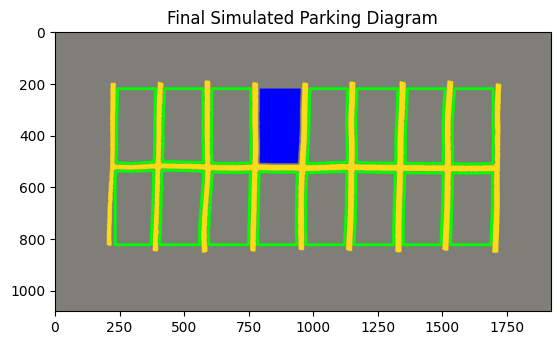

In [39]:
# Displaying the final parking diagram with detected spaces and simulated parked car
plt.title('Final Simulated Parking Diagram')
plt.imshow(cpl_copy);

In [40]:
# Converting the final image from RGB to BGR to save it to disk
cpl_copy = cv2.cvtColor(cpl_copy, cv2.COLOR_RGB2BGR)

# Saving the file back into our repo
cv2.imwrite('../data/processed/simulated_parking_lot.jpeg', cpl_copy)

True

## Wrapping Up
That brings us to the end of this notebook! I hope you can see how this will all piece together as we start to bring in the true car detection. Again, what we did here is definitely not going to work for every single parking lot. The goal here was to show you how to think creatively with the functions of OpenCV to automate the process for your own use case. Hope you enjoyed working through this notebook as much as I have! 🚘